In [1]:
# A Face Detection Pipeline

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

/tmp/ipykernel_615643/97475571.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
# HOG Features
"""
1. Optionally prenormalize the images. This leads to features that resist dependence
on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical
brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram
of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring
cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.
"""

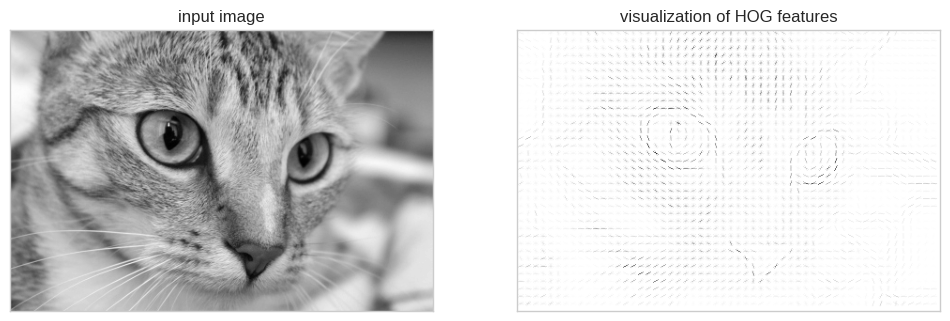

In [2]:
from skimage import data, color, feature
import skimage.data
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [ ]:
# HOG in Action: A Simple Face Detector
"""
1. Obtain a set of image thumbnails of faces to constitute “positive” training
samples.
2. Obtain a set of image thumbnails of non-faces to constitute “negative” training
samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an “unknown” image, pass a sliding window across the image, using the
model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.
"""

In [3]:
# 1. Obtain a Set of Positive Training Samples

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [4]:
# 2. Obtain a Set of Negative Training Samples

data.camera().shape

(512, 512)

In [5]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
'page', 'clock', 'immunohistochemistry',
'chelsea', 'coffee', 'hubble_deep_field']
raw_images = (getattr(data, name)() for name in imgs_to_use)
images = [color.rgb2gray(image) if image.ndim == 3 else image
for image in raw_images]

In [6]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
    max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
        for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

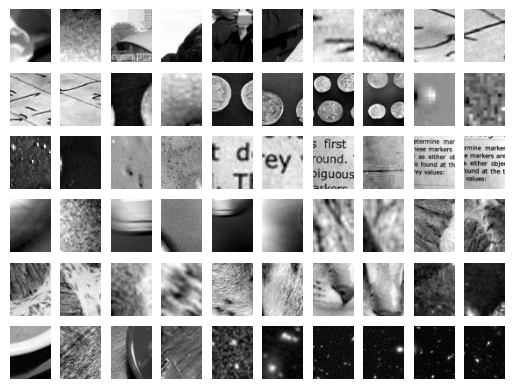

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [8]:
# 3. Combine Sets and Extract HOG Features

from itertools import chain
X_train = np.array([feature.hog(im)
for im in chain(positive_patches,
negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [9]:
X_train.shape

(43233, 1215)

In [10]:
# 4. Train a Support Vector Machine

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.95732624, 0.972476  , 0.97340118, 0.97628961, 0.97490169])

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/home/x057/anaconda31/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/x057/anaconda31/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/x057/anaconda31/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/x057/anaconda31/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/x057/anaconda31/lib/py

0.9885272700574659

In [12]:
grid.best_params_

{'C': 2.0}

In [13]:
model = grid.best_estimator_
model.fit(X_train, y_train)

/home/x057/anaconda31/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=2.0)

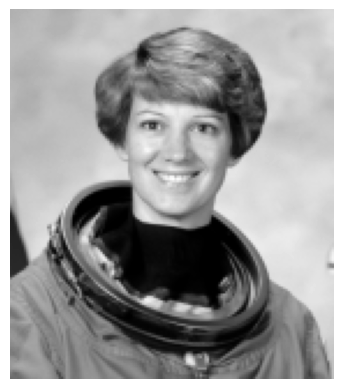

In [14]:
# 5. Find Faces in a New Image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [15]:
def sliding_window(img, patch_size=positive_patches[0].shape,
    istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [16]:
labels = model.predict(patches_hog)
labels.sum()

46.0

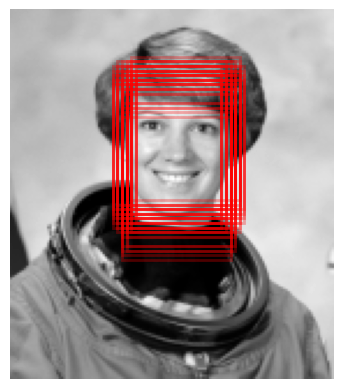

In [18]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
        alpha=0.3, lw=2, facecolor='none'))